# 纽约市出租车行程预测
## 一、数据处理
### 1.1 数据来源
除了给定的出租车数据，在网上还找到了一下数据集：
- [出租车行程数据集](https://www.kaggle.com/datasets/yasserh/nyc-taxi-trip-duration)
- [2016年纽约市天气数据](https://www.kaggle.com/datasets/cabaki/knycmetars2016?resource=download)
- [2016年纽约市节假日数据](https://www.kaggle.com/datasets/pceccon/nyc2016holidays)
- [2016年纽约市1KM分辨率人口](https://hub.worldpop.org/geodata/summary?id=80022)



In [56]:
# taxi_travel_time_prediction.ipynb
import pandas as pd
import numpy as np
from datetime import datetime, date

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, KMeans
import optuna
import optuna.integration.lightgbm as oplgb

import warnings
warnings.filterwarnings('ignore')

### 1.2读取数据集

In [57]:
# 1.读取训练和预测集
# 参数parse_dates可以解析日期格式
data_df = pd.read_csv('../实习二数据/train.csv', parse_dates=['pickup_datetime', 'dropoff_datetime'])
# 划分训练集，测试集和验证集（0.7 0.3 ）
train_df, valid_df = np.split(data_df, [int(len(data_df) * 0.7)])
# 删除data_df，释放内存
del data_df
dfs = [train_df, valid_df]

# 显示数据集的前1行
print(dfs[0].shape, dfs[1].shape)
print("训练集和验证集的前1行数据：")
print(dfs[0].head(1))
print(dfs[1].head(1))

# 2.读取节假日数据
holiday = pd.read_csv('../实习二数据/NYC_2016Holidays.csv', sep=';', parse_dates=['Date'])
# 将假期数据转换为与数据集一致的datetime格式
holiday['Date'] = holiday['Date'].apply(lambda x: x + ' 2016')
holidays = [datetime.strptime(holiday.loc[i, 'Date'], '%B %d %Y').date() for i in range(len(holiday))]
holidays[:3]

# 3.读取天气数据
# 读取天气数据
weather = pd.read_csv('../实习二数据/KNYC_Metars.csv', parse_dates=['Time'])
print("天气数据集前一行：")
print(weather.head(1))

(1021050, 11) (437594, 11)
训练集和验证集的前1行数据：
          id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1            -73.98            40.77             -73.96   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0             40.77                  N            455  
                id  vendor_id     pickup_datetime    dropoff_datetime  \
1021050  id1319211          2 2016-04-28 17:41:35 2016-04-28 17:50:53   

         passenger_count  pickup_longitude  pickup_latitude  \
1021050                5            -74.01            40.71   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  trip_duration  
1021050             -74.01             40.72                  N            558  
天气数据集前一行：
                 Time  Temp.  Windchill  Heat Index  Humidity  Pressure  \
0 2015-12-31 02:00:00   7.80       7.

## 二、数据清洗

缺失值检查：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021050 entries, 0 to 1021049
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1021050 non-null  object        
 1   vendor_id           1021050 non-null  int64         
 2   pickup_datetime     1021050 non-null  datetime64[ns]
 3   dropoff_datetime    1021050 non-null  datetime64[ns]
 4   passenger_count     1021050 non-null  int64         
 5   pickup_longitude    1021050 non-null  float64       
 6   pickup_latitude     1021050 non-null  float64       
 7   dropoff_longitude   1021050 non-null  float64       
 8   dropoff_latitude    1021050 non-null  float64       
 9   store_and_fwd_flag  1021050 non-null  object        
 10  trip_duration       1021050 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 85.7+ MB
描述性统计：
       vendor_id                picku

<Axes: ylabel='trip_duration'>

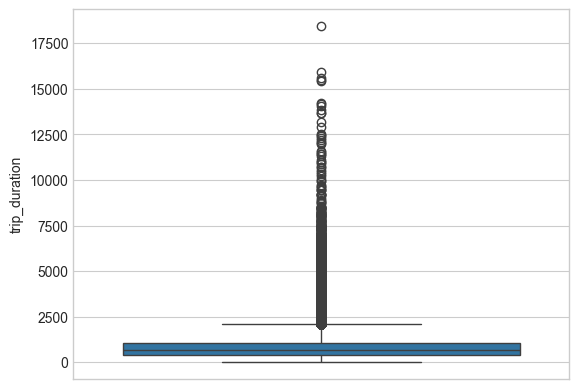

In [58]:
# 1.检查缺失值
print("缺失值检查：")
dfs[0].info() # 根据输出未发现缺失值

# 2.异常值
# 2.1 描述型统计
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print("描述性统计：")
print(dfs[0].describe())# 查看描述性统计，发现有不合理的值

# 2.2 passenger_count异常值处理
print("训练集和测试集的passenger_count各种取值数量：")
print(dfs[0].passenger_count.value_counts())
print(dfs[1].passenger_count.value_counts())
for i in range(len(dfs)):
    dfs[i]['passenger_count'].replace({
            0:1,7:6,8:6,9:6},inplace=True) # 采用最邻近替换掉异常值

# 2.3 trip_duration异常值处理
# 查看trip_duration的均值、标准差
time_mean = np.mean(dfs[0].trip_duration)
time_std = np.std(dfs[0].trip_duration)
print(time_mean, time_std)
# 删除异常值
for i in range(len(dfs)):

    dfs[i] = dfs[i][(dfs[i]['trip_duration']<=(time_mean + 3 * time_std)) & (dfs[i]['trip_duration']>=(time_mean - 3 * time_std))]
    # 用正态删除了最大的异常值，但没有删除最小的异常值
    dfs[i] = dfs[i][dfs[i]['trip_duration']!=1]
sns.boxplot(dfs[0]['trip_duration'])# 查看去除异常值后的trip_duration分布

## 三、特征工程
### 3.1 时间特征

- 由上面的分析可以发现，trip_duration的标准差为5237.43，说明行程时间数据差异大，为减小数据差异带来的干扰，将数据log化：log_trip_duration
- 提取时间特征
- 是否是工作日、节假日
- 将时段分为早晚高峰、白天、夜晚

log_trip_duration分布：


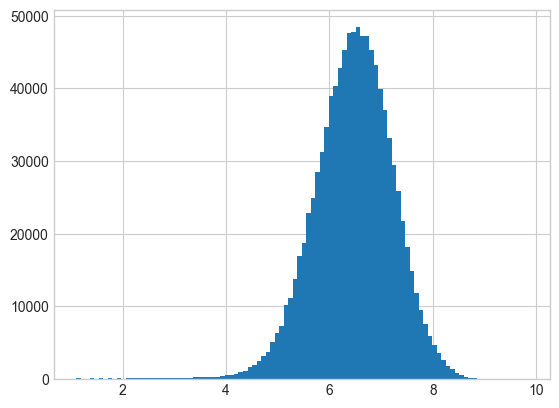

In [59]:
# 3.1 log_trip_duration取对数
for i, d in enumerate(dfs):
    dfs[i]['log_trip_duration'] = np.log(dfs[i]['trip_duration'].values + 1)
print("log_trip_duration分布：")
plt.hist(dfs[0]['log_trip_duration'].values, bins=100)
plt.show()

# 3.2 提取时间特征
# 提取年、月、日、小时、分钟、星期、日期
for i, d in enumerate(dfs):
    dfs[i]['year'] = d.pickup_datetime.dt.year
    dfs[i]['month'] = d.pickup_datetime.dt.month
    dfs[i]['day'] = d.pickup_datetime.dt.day
    dfs[i]['hour'] = d.pickup_datetime.dt.hour
    dfs[i]['minute'] = d.pickup_datetime.dt.minute
    dfs[i]['dayofweek'] = d.pickup_datetime.dt.dayofweek
    dfs[i]['date'] = d.pickup_datetime.dt.date
    dfs[i]['time'] = d.hour + d.minute/60

# 判断是否工作日、是否节假日
for i, d in enumerate(dfs):
    dfs[i]['is_weekend'] = d['dayofweek'].apply(lambda x: 1 if x==5 or x==6 else 0)
    dfs[i]['is_rest'] = d['date'].apply(lambda x: 1 if x in holidays else 0)

# 24小时切分为不同时段：早高峰、晚高峰、白天、夜晚
def get_time_interval(series):
    hour = series['hour']
    is_rest = series['is_rest']
    
    if is_rest==1:
        if hour>=7 and hour<=21:
            time_interval='day'
        elif hour>21 or hour<7:
            time_interval='night'
    elif is_rest==0:
        if hour>=7 and hour<=9: 
            time_interval='morning_peak'
        elif hour>=17 and hour<=21:
            time_interval='evening_peak'
        elif hour>9 and hour<17:
            time_interval='day'
        elif hour>21 or hour<7:
            time_interval='night'
    return time_interval

for i, d in enumerate(dfs):
    dfs[i]['time_interval'] = d.apply(get_time_interval, axis=1)



### 3.2 天气特征  

In [60]:
# 3.3 天气特征
print("各类天气数量：")
print(weather.Events.value_counts())
# 将天气加上时间标签：
# 提取天气特征的年月日等时间特征，并筛选年份天气等特征。
weather['year'] = weather.Time.dt.year
weather['month'] = weather.Time.dt.month
weather['day'] = weather.Time.dt.day
weather['hour'] = weather.Time.dt.hour
weather['events_weather'] = weather['Events'].apply(lambda x: 0 if x=='None' else 1)
weather = weather[weather['year']==2016][['Temp.', 'Visibility', 'events_weather', 'month', 'day','hour', 'Precip']]
# 与上车时间合并
for i, d in enumerate(dfs):
    dfs[i] = pd.merge(d, weather, on=['month', 'day', 'hour'], how='left')

各类天气数量：
Events
Rain              377
Snow               51
Fog\n\t,\nSnow     23
Fog                 2
Fog\n\t,\nRain      2
Name: count, dtype: int64


### 3.3 距离特征

In [61]:
# 计算经纬度之间的距离
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return round(c * 6371, 3) # 地球平均半径，6371km

# 单位：km
for i, d in enumerate(dfs):
    dfs[i]['haversine'] = d.apply(lambda x: haversine(x['pickup_longitude'], x['pickup_latitude'], x['dropoff_longitude'], x['dropoff_latitude']), axis=1)

### 3.4 区域特征
- 对经纬度用kmeans聚类，创建区域特征分为15个类别：(感觉不太好)
数据集太大，所以用MiniBatchKMeans代替，能够对小规模子集进行计算，减少计算时间。
- 对经纬度用PCA，创建新特征

#### 3.4.1 增加投影坐标系

In [62]:
from pyproj import Transformer

# 定义坐标转换器（WGS84→UTM18N，纽约适用）
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32618", always_xy=True)

# 为每个数据集添加上下车投影坐标
for df in dfs:
    # 上车点投影坐标
    df['pickup_x'], df['pickup_y'] = transformer.transform(
        df['pickup_longitude'].values, 
        df['pickup_latitude'].values
    )
    # 下车点投影坐标
    df['dropoff_x'], df['dropoff_y'] = transformer.transform(
        df['dropoff_longitude'].values, 
        df['dropoff_latitude'].values
    )

#### 3.4.2 坐标聚类与主成分分析

In [63]:

# 先将所有需要转换的数据汇总，一起放入fit

coords = np.vstack((dfs[0][['pickup_x', 'pickup_y']].values,
                    dfs[0][['dropoff_x', 'dropoff_y']].values))
# 随机采样
sample_ids = np.random.permutation(len(coords))[:1000000]
kmeans = MiniBatchKMeans(init='k-means++', n_clusters=15, batch_size=10000).fit(coords[sample_ids])

# 聚类
for i, d in enumerate(dfs):
    dfs[i]['pickup_cluster'] = kmeans.predict(d[['pickup_x', 'pickup_y']])
    dfs[i]['dropoff_cluster'] = kmeans.predict(d[['dropoff_x', 'dropoff_y']])

print(pd.concat([dfs[0], dfs[1]]).groupby(['pickup_cluster']).size().reset_index())

# PCA
pca = PCA().fit(coords)
for i, d in enumerate(dfs):
    dfs[i]['pickup_pca0'] = pca.transform(d[['pickup_x', 'pickup_y']])[:, 0]
    dfs[i]['pickup_pca1'] = pca.transform(d[['pickup_x', 'pickup_y']])[:, 1]
    dfs[i]['dropoff_pca0'] = pca.transform(d[['dropoff_x', 'dropoff_y']])[:, 0]
    dfs[i]['dropoff_pca1'] = pca.transform(d[['dropoff_x', 'dropoff_y']])[:, 1]

    pickup_cluster       0
0                0   33108
1                1  125060
2                2  158531
3                3  169807
4                4  104446
5                5   41641
6                6   10824
7                7  197899
8                8    7192
9                9  122669
10              10  121568
11              11  104929
12              12   68346
13              13  181500
14              14    9020


### 3.5 速度
- 根据haversine距离与trip_duration计算车速：speed=haversine(km)×1000/trip_duration，单位m/s
- 由于test无法计算haversine speed，所以根据haversine speed计算每个区域的平均速度

#### 3.5.1 Voronoi 图划分
- 因为不知道测试集和验证集的行驶时间，所以无法计算速度，为了使用速度特征，根据上面的聚类结果，进行Voronoi 图划分，利用训练集，计算每一个区域划分的平均速度

- 计算区域剖分里的平均速度

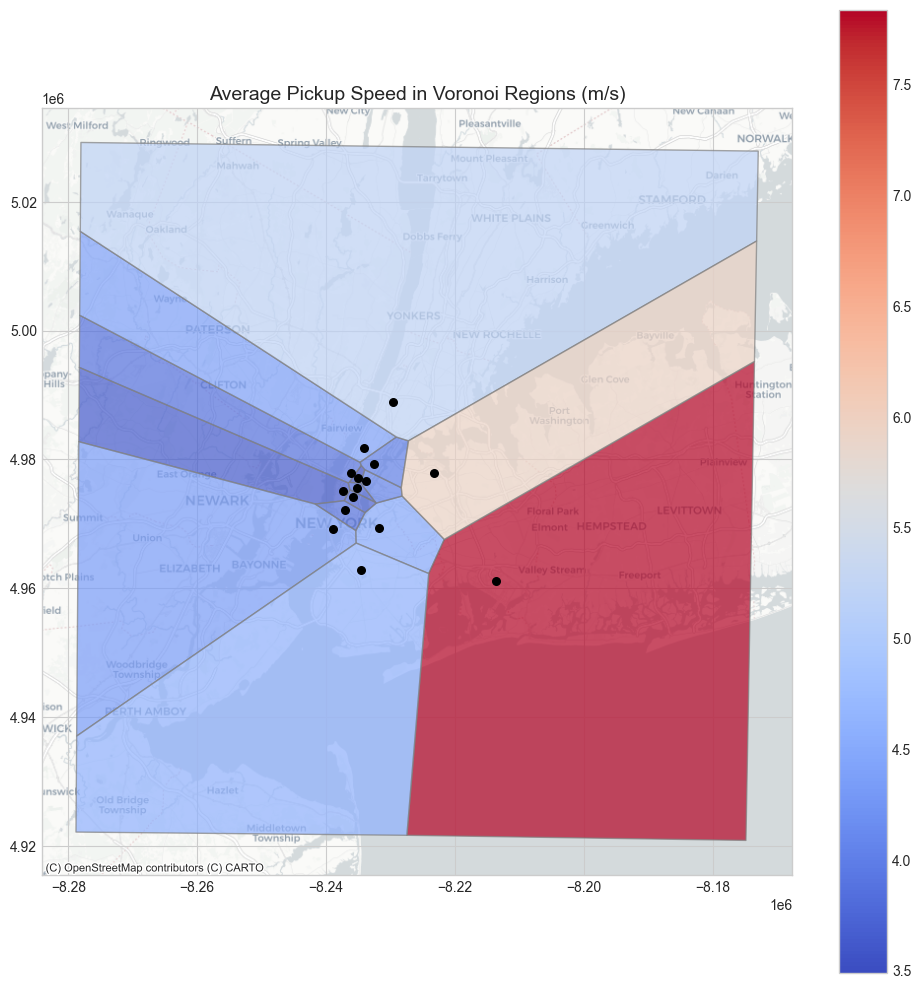

In [64]:
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import voronoi_diagram
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gc

# ========= 1. 基于 KMeans 聚类中心构建 Voronoi 区域 =========
centers = kmeans.cluster_centers_
# centers shape: (n_clusters, 2) -> order is (x, y) i.e. (pickup_x, pickup_y)
points = gpd.GeoSeries([Point(x, y) for x, y in centers], crs="EPSG:32618")

# 使用 union_all()（替代 unary_union）构建 envelope 并生成 Voronoi
# buffer 的大小按城市尺度调整（这里 30km）
multi = points.union_all()
envelope = multi.buffer(30000)  
vor = voronoi_diagram(multi, envelope=envelope)
vor_polygons = list(vor.geoms)

vor_gdf = gpd.GeoDataFrame({
    'region_id': range(len(vor_polygons)),
    'geometry': vor_polygons
}, crs="EPSG:32618")

# ========= 2. 计算训练集速度（m/s）并清理异常值 =========
train = dfs[0].copy()
# 假定 haversine 是以 km 为单位，trip_duration 单位为秒
train['speed'] = train['haversine'] * 1000 / train['trip_duration']
train = train.loc[train['speed'].between(0.1, 150)].reset_index(drop=True)

# ========= 3. 计算 pickup 区域平均速度 =========
pickup_gdf = gpd.GeoDataFrame(
    train[['pickup_x', 'pickup_y', 'speed']].copy(),
    geometry=gpd.points_from_xy(train['pickup_x'], train['pickup_y']),
    crs="EPSG:32618"
)
# 空间连接：每个点落在哪个 voronoi polygon 内
pickup_join = gpd.sjoin(pickup_gdf, vor_gdf[['region_id', 'geometry']], how='left', predicate='within')

pickup_speed = (
    pickup_join.groupby('region_id')['speed']
    .mean()
    .reset_index()
    .rename(columns={'speed': 'avg_pickup_speed'})
)

# ========= 4. 计算 dropoff 区域平均速度 =========
drop_gdf = gpd.GeoDataFrame(
    train[['dropoff_x', 'dropoff_y', 'speed']].copy(),
    geometry=gpd.points_from_xy(train['dropoff_x'], train['dropoff_y']),
    crs="EPSG:32618"
)
drop_join = gpd.sjoin(drop_gdf, vor_gdf[['region_id', 'geometry']], how='left', predicate='within')

drop_speed = (
    drop_join.groupby('region_id')['speed']
    .mean()
    .reset_index()
    .rename(columns={'speed': 'avg_dropoff_speed'})
)

# ========= 5. 合并速度回 Voronoi 区域 =========
vor_gdf = vor_gdf.merge(pickup_speed, on='region_id', how='left')
vor_gdf = vor_gdf.merge(drop_speed, on='region_id', how='left')

# 计算全局回退值（若某些 region 没有样本）
global_avg_pick = vor_gdf['avg_pickup_speed'].mean(skipna=True)
global_avg_drop = vor_gdf['avg_dropoff_speed'].mean(skipna=True)

# 用全局均值填充 Voronoi 中的 NaN （避免以后映射到 NaN）
vor_gdf['avg_pickup_speed'] = vor_gdf['avg_pickup_speed'].fillna(global_avg_pick)
vor_gdf['avg_dropoff_speed'] = vor_gdf['avg_dropoff_speed'].fillna(global_avg_drop)

# ========= 6. 为 dfs 中每个 DataFrame 添加特征（不删除任何 dfs） =========
# 说明：为了保持原始 df 行顺序，我们在 sjoin 后根据原索引把特征写回
for idx, df in enumerate(dfs):
    # 上车特征
    gdf_pick = gpd.GeoDataFrame(
        df[['pickup_x', 'pickup_y']].copy(),
        geometry=gpd.points_from_xy(df['pickup_x'], df['pickup_y']),
        crs="EPSG:32618"
    )
    joined_pick = gpd.sjoin(gdf_pick, vor_gdf[['region_id', 'avg_pickup_speed', 'geometry']],
                            how='left', predicate='within')
    # joined_pick 保持与 gdf_pick 相同的 index（通常为原 df index），但以防万一，reindex到原 df.index
    joined_pick = joined_pick.reindex(df.index)
    # 若有缺失，再回退为全局平均
    pick_vals = joined_pick['avg_pickup_speed'].fillna(global_avg_pick).to_numpy()
    df['avg_pickup_speed'] = pick_vals

    # 下车特征
    gdf_drop = gpd.GeoDataFrame(
        df[['dropoff_x', 'dropoff_y']].copy(),
        geometry=gpd.points_from_xy(df['dropoff_x'], df['dropoff_y']),
        crs="EPSG:32618"
    )
    joined_drop = gpd.sjoin(gdf_drop, vor_gdf[['region_id', 'avg_dropoff_speed', 'geometry']],
                            how='left', predicate='within')
    joined_drop = joined_drop.reindex(df.index)
    drop_vals = joined_drop['avg_dropoff_speed'].fillna(global_avg_drop).to_numpy()
    df['avg_dropoff_speed'] = drop_vals

    # 删除临时 geometry 列（保持原 df 结构）
    # 注意我们在修改 dfs 中的 df（原地修改），因此不需要赋值回 dfs
    if 'geometry' in df.columns:
        df.drop(columns='geometry', inplace=True)

# ========= 7. 释放中间变量以节省内存（可选） =========
del pickup_gdf, drop_gdf, pickup_join, drop_join, pickup_speed, drop_speed, train, gdf_pick, gdf_drop, joined_pick, joined_drop
gc.collect()

# ========= 8. 可视化：绘制 Voronoi 区域 + 底图（显示 avg_pickup_speed） =========
try:
    import contextily as ctx
    vor_gdf_web = vor_gdf.to_crs(epsg=3857)

    fig, ax = plt.subplots(figsize=(10, 10))
    vor_gdf_web.plot(
        ax=ax,
        column='avg_pickup_speed',
        cmap='coolwarm',
        legend=True,
        edgecolor='gray',
        alpha=0.7
    )
    # 把聚类中心点也画到地图上（转换到 web mercator）
    centers_gdf = gpd.GeoDataFrame(geometry=points, crs="EPSG:32618").to_crs(epsg=3857)
    centers_gdf.plot(ax=ax, color='black', markersize=30, label='KMeans Centers')

    ctx.add_basemap(ax, crs=vor_gdf_web.crs, source=ctx.providers.CartoDB.Positron)
    ax.set_title("Average Pickup Speed in Voronoi Regions (m/s)", fontsize=14)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("可视化（带底图）未能执行，原因：", e)
    print("你可以通过 pip install contextily 来启用底图支持；或仅使用 vor_gdf.plot(...) 查看矢量图。")


### 3.6 人口特征


In [65]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import rowcol

# --------------------------
# 1. 核心函数：根据经纬度提取人口密度
# --------------------------
def get_population_density(tif_path, lon, lat):
    """通用函数：根据经纬度（lon, lat）提取对应位置的人口密度"""
    with rasterio.open(tif_path) as src:
        # 经纬度转TIF行列索引
        rows, cols = rowcol(src.transform, lon, lat)
        
        # 索引边界处理
        rows = np.clip(rows, 0, src.height - 1)
        cols = np.clip(cols, 0, src.width - 1)
        
        # 读取人口密度（假设第1波段为密度值）
        pop_density = src.read(1)[rows, cols]
        
        # 处理无效值（NoData）
        nodata = src.nodata if src.nodata is not None else -9999
        pop_density = np.where(pop_density == nodata, np.nan, pop_density)
        
        # 用整体平均值填充缺失
        mean_density = np.nanmean(pop_density)
        return np.nan_to_num(pop_density, nan=mean_density)

# --------------------------
# 2. 添加上车点+下车点人口密度特征
# --------------------------
# 替换为你的NYC人口TIF路径
NYC_POP_TIF = "../实习二数据/nyc_population_2016.tif"  # 例如："nyc_pop_raster.tif"

# 遍历所有数据框（train/test）
for i in range(len(dfs)):
    # 1. 上车点人口密度
    pickup_lon = dfs[i]['pickup_longitude'].values
    pickup_lat = dfs[i]['pickup_latitude'].values
    dfs[i]['pickup_pop_density'] = get_population_density(NYC_POP_TIF, pickup_lon, pickup_lat)
    
    # 2. 下车点人口密度
    dropoff_lon = dfs[i]['dropoff_longitude'].values
    dropoff_lat = dfs[i]['dropoff_latitude'].values
    dfs[i]['dropoff_pop_density'] = get_population_density(NYC_POP_TIF, dropoff_lon, dropoff_lat)

# --------------------------
# 3. 检查结果
# --------------------------
print("添加上下车点人口密度后的前5行数据：")
print(dfs[0][[
    'id', 'pickup_longitude', 'pickup_latitude', 'pickup_pop_density',
    'dropoff_longitude', 'dropoff_latitude', 'dropoff_pop_density',
    'trip_duration'
]].head())

添加上下车点人口密度后的前5行数据：
          id  pickup_longitude  pickup_latitude  pickup_pop_density  \
0  id2875421            -73.98            40.77            11674.00   
1  id2377394            -73.98            40.74            32831.08   
2  id3858529            -73.98            40.76            10337.24   
3  id3504673            -74.01            40.72             9841.03   
4  id2181028            -73.97            40.79            36603.33   

   dropoff_longitude  dropoff_latitude  dropoff_pop_density  trip_duration  
0             -73.96             40.77             29462.14            455  
1             -74.00             40.73             20344.47            663  
2             -74.01             40.71             15132.38           2124  
3             -74.01             40.71              8950.64            429  
4             -73.97             40.78               969.62            435  


### 3.7 分类变量转换
- store_and_fwd_flag、time_interval，进行dummy操作

In [66]:
for i, d in enumerate(dfs):
    store_and_fwd_flag_dummy = pd.get_dummies(d.store_and_fwd_flag, prefix='sff', prefix_sep='_')
    time_interval_dummy = pd.get_dummies(d.time_interval, prefix='ti', prefix_sep='_')

    dfs[i] = pd.concat([d, store_and_fwd_flag_dummy, time_interval_dummy], axis = 1)

## 五、建模

In [68]:
# 5.1.1 指定特征
features = ['vendor_id', 'passenger_count', 'pickup_longitude', 
            'pickup_latitude', 'dropoff_longitude', 
            'dropoff_latitude', 'month', 'day', 'hour', 
            'minute', 'dayofweek', 'time', 'is_weekend', 
            'is_rest', 'Temp.', 'Visibility', 
            'events_weather', 'Precip', 'haversine', 
            'pickup_cluster', 'dropoff_cluster', 
            'avg_pickup_speed', 'avg_dropoff_speed', 'sff_N', 
            'sff_Y', 'ti_day', 'ti_morning_peak', 'ti_night', 'ti_evening_peak', 'pickup_pca0', 'pickup_pca1',
            'dropoff_pca0', 'dropoff_pca1','pickup_pop_density','dropoff_pop_density']

# 划分数据集
RANDOM_SEED = 42
train_X = dfs[0][features]
train_y = dfs[0]['log_trip_duration']
val_X = dfs[1][features]
val_y = dfs[1]['log_trip_duration']
# test_X = dfs[2][features]
# test_y = dfs[2]['log_trip_duration']


### 5.2 评价指标

In [69]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y_pred), 2)))

### 5.3LightGBM模型训练

#### 5.3.1 超参数最优化

In [70]:
from lightgbm import early_stopping, LGBMRegressor
import optuna
import matplotlib.pyplot as plt
import numpy as np

# 假设你已定义 RANDOM_SEED、train_X、val_X、rmsle 等变量

def objective(trial):
    param = {
        'random_state': RANDOM_SEED, 
        'n_estimators': 1000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [5, 7, 9, 11, 13, 15, 17, 20, 50]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('cat_smooth', 1, 100)      
    }
    
    lgb = LGBMRegressor(**param)
    lgb.fit(
        train_X, train_y,
        eval_set=[(val_X, val_y)],
        callbacks=[early_stopping(stopping_rounds=20,verbose=False)]
    )
    pred_lgb = lgb.predict(val_X)
    return rmsle(val_y, pred_lgb)

# 执行超参数搜索
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
print('Best trial:', study.best_trial.params)
print("------------------------------------------------")
print(study.trials_dataframe())
#best_params = {'reg_alpha': 1.1640780838556473, 'reg_lambda': 0.7724034939295659, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.017, 'max_depth': 50, 'num_leaves': 903, 'min_child_samples': 230, 'cat_smooth': 79}



[I 2025-10-23 18:07:40,376] A new study created in memory with name: no-name-0dd0eed8-e649-4afa-aebc-dc7f1148d454


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3298
[LightGBM] [Info] Number of data points in the train set: 1019579, number of used features: 35
[LightGBM] [Info] Start training from score 6.460105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-10-23 18:08:22,874] Trial 0 finished with value: 0.05943193503359444 and parameters: {'reg_alpha': 0.2566967742747266, 'reg_lambda': 0.00547513724456918, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.006, 'max_depth': 7, 'num_leaves': 549, 'min_child_samples': 75, 'cat_smooth': 46}. Best is trial 0 with value: 0.05943193503359444.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3298
[LightGBM] [Info] Number of data points in the train set: 1019579, number of used features: 35
[LightGBM] [Info] Start training from score 6.460105


[I 2025-10-23 18:09:17,047] Trial 1 finished with value: 0.055710472959047415 and parameters: {'reg_alpha': 6.329011779311675, 'reg_lambda': 4.42971324343081, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 97, 'min_child_samples': 256, 'cat_smooth': 12}. Best is trial 1 with value: 0.055710472959047415.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3298
[LightGBM] [Info] Number of data points in the train set: 1019579, number of used features: 35
[LightGBM] [Info] Start training from score 6.460105


[I 2025-10-23 18:09:48,859] Trial 2 finished with value: 0.05757269260991451 and parameters: {'reg_alpha': 3.84206284073046, 'reg_lambda': 1.3966990232738974, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 11, 'num_leaves': 58, 'min_child_samples': 284, 'cat_smooth': 33}. Best is trial 1 with value: 0.055710472959047415.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3298
[LightGBM] [Info] Number of data points in the train set: 1019579, number of used features: 35
[LightGBM] [Info] Start training from score 6.460105


[I 2025-10-23 18:11:47,214] Trial 3 finished with value: 0.054686402741662 and parameters: {'reg_alpha': 1.1841740342874, 'reg_lambda': 3.0819239108614442, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 13, 'num_leaves': 786, 'min_child_samples': 3, 'cat_smooth': 90}. Best is trial 3 with value: 0.054686402741662.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3298
[LightGBM] [Info] Number of data points in the train set: 1019579, number of used features: 35
[LightGBM] [Info] Start training from score 6.460105


[I 2025-10-23 18:12:47,380] Trial 4 finished with value: 0.05421747734229196 and parameters: {'reg_alpha': 0.9517946506357289, 'reg_lambda': 0.002213144041749939, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 13, 'num_leaves': 238, 'min_child_samples': 59, 'cat_smooth': 65}. Best is trial 4 with value: 0.05421747734229196.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3298
[LightGBM] [Info] Number of data points in the train set: 1019579, number of used features: 35
[LightGBM] [Info] Start training from score 6.460105


[I 2025-10-23 18:14:00,218] Trial 5 finished with value: 0.05507154951299011 and parameters: {'reg_alpha': 0.037340432049748934, 'reg_lambda': 0.09166349208078597, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 15, 'num_leaves': 280, 'min_child_samples': 199, 'cat_smooth': 14}. Best is trial 4 with value: 0.05421747734229196.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3298
[LightGBM] [Info] Number of data points in the train set: 1019579, number of used features: 35
[LightGBM] [Info] Start training from score 6.460105


[I 2025-10-23 18:15:04,279] Trial 6 finished with value: 0.0539911771616315 and parameters: {'reg_alpha': 5.824248246628287, 'reg_lambda': 0.017860929367268994, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 17, 'num_leaves': 314, 'min_child_samples': 35, 'cat_smooth': 37}. Best is trial 6 with value: 0.0539911771616315.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3298
[LightGBM] [Info] Number of data points in the train set: 1019579, number of used features: 35
[LightGBM] [Info] Start training from score 6.460105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-23 18:16:22,069] Trial 7 finished with value: 0.0540157002032142 and parameters: {'reg_alpha': 0.14259278312985418, 'reg_lambda': 1.7508854901551671, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 11, 'num_leaves': 698, 'min_child_samples': 280, 'cat_smooth': 49}. Best is trial 6 with value: 0.0539911771616315.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3298
[LightGBM] [Info] Number of data points in the train set: 1019579, number of used features: 35
[LightGBM] [Info] Start training from score 6.460105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-10-23 18:17:52,035] Trial 8 finished with value: 0.05433390003486897 and parameters: {'reg_alpha': 0.7958262649043611, 'reg_lambda': 0.1286023700277549, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 11, 'num_leaves': 790, 'min_child_samples': 156, 'cat_smooth': 35}. Best is trial 6 with value: 0.0539911771616315.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3298
[LightGBM] [Info] Number of data points in the train set: 1019579, number of used features: 35
[LightGBM] [Info] Start training from score 6.460105


[I 2025-10-23 18:19:47,584] Trial 9 finished with value: 0.055246475955859374 and parameters: {'reg_alpha': 3.26310276921539, 'reg_lambda': 0.897097667033649, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.006, 'max_depth': 50, 'num_leaves': 665, 'min_child_samples': 157, 'cat_smooth': 90}. Best is trial 6 with value: 0.0539911771616315.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3298
[LightGBM] [Info] Number of data points in the train set: 1019579, number of used features: 35
[LightGBM] [Info] Start training from score 6.460105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-10-23 18:21:43,836] Trial 10 finished with value: 0.05314759846440377 and parameters: {'reg_alpha': 0.0019860063243609064, 'reg_lambda': 0.01233672295924712, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 17, 'num_leaves': 980, 'min_child_samples': 81, 'cat_smooth': 69}. Best is trial 10 with value: 0.05314759846440377.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3298
[LightGBM] [Info] Number of data points in the train set: 1019579, number of used features: 35
[LightGBM] [Info] Start training from score 6.460105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-10-23 18:22:53,780] Trial 11 finished with value: 0.053859053862031096 and parameters: {'reg_alpha': 0.0015657158549107872, 'reg_lambda': 0.017546913453921145, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 17, 'num_leaves': 409, 'min_child_samples': 76, 'cat_smooth': 69}. Best is trial 10 with value: 0.05314759846440377.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3298
[LightGBM] [Info] Number of data points in the train set: 1019579, number of used features: 35
[LightGBM] [Info] Start training from score 6.460105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-10-23 18:24:52,636] Trial 12 finished with value: 0.053141646983994255 and parameters: {'reg_alpha': 0.0013132314147891945, 'reg_lambda': 0.023352014799508353, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 17, 'num_leaves': 981, 'min_child_samples': 101, 'cat_smooth': 68}. Best is trial 12 with value: 0.053141646983994255.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3298
[LightGBM] [Info] Number of data points in the train set: 1019579, number of used features: 35
[LightGBM] [Info] Start training from score 6.460105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-10-23 18:26:54,130] Trial 13 finished with value: 0.053162838887173464 and parameters: {'reg_alpha': 0.003560527027183912, 'reg_lambda': 0.05838504636716796, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.017, 'max_depth': 17, 'num_leaves': 997, 'min_child_samples': 118, 'cat_smooth': 73}. Best is trial 12 with value: 0.053141646983994255.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3298
[LightGBM] [Info] Number of data points in the train set: 1019579, number of used features: 35
[LightGBM] [Info] Start training from score 6.460105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-10-23 18:27:28,292] Trial 14 finished with value: 0.05887886703146208 and parameters: {'reg_alpha': 0.010343123265336818, 'reg_lambda': 0.001571915283988316, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.017, 'max_depth': 5, 'num_leaves': 901, 'min_child_samples': 119, 'cat_smooth': 78}. Best is trial 12 with value: 0.053141646983994255.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3298
[LightGBM] [Info] Number of data points in the train set: 1019579, number of used features: 35
[LightGBM] [Info] Start training from score 6.460105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-23 18:28:39,644] Trial 15 finished with value: 0.05439231685419816 and parameters: {'reg_alpha': 0.0011844467220685946, 'reg_lambda': 0.3602537826853816, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 9, 'num_leaves': 975, 'min_child_samples': 102, 'cat_smooth': 100}. Best is trial 12 with value: 0.053141646983994255.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3298
[LightGBM] [Info] Number of data points in the train set: 1019579, number of used features: 35
[LightGBM] [Info] Start training from score 6.460105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-23 18:30:56,740] Trial 16 finished with value: 0.05380529898888856 and parameters: {'reg_alpha': 0.014569528112662957, 'reg_lambda': 0.020575646476212104, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 17, 'num_leaves': 862, 'min_child_samples': 195, 'cat_smooth': 58}. Best is trial 12 with value: 0.053141646983994255.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3298
[LightGBM] [Info] Number of data points in the train set: 1019579, number of used features: 35
[LightGBM] [Info] Start training from score 6.460105


[I 2025-10-23 18:32:21,434] Trial 17 finished with value: 0.055439336332640546 and parameters: {'reg_alpha': 0.0053961550955308355, 'reg_lambda': 0.004951866276113334, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.008, 'max_depth': 17, 'num_leaves': 541, 'min_child_samples': 26, 'cat_smooth': 79}. Best is trial 12 with value: 0.053141646983994255.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3298
[LightGBM] [Info] Number of data points in the train set: 1019579, number of used features: 35
[LightGBM] [Info] Start training from score 6.460105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-10-23 18:32:47,297] Trial 18 finished with value: 0.05892669100483434 and parameters: {'reg_alpha': 0.027762127994838803, 'reg_lambda': 0.008376028485938191, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.017, 'max_depth': 5, 'num_leaves': 666, 'min_child_samples': 190, 'cat_smooth': 59}. Best is trial 12 with value: 0.053141646983994255.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3298
[LightGBM] [Info] Number of data points in the train set: 1019579, number of used features: 35
[LightGBM] [Info] Start training from score 6.460105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-10-23 18:34:52,291] Trial 19 finished with value: 0.0527721848331105 and parameters: {'reg_alpha': 0.0031004122167636165, 'reg_lambda': 0.24259286315353665, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 880, 'min_child_samples': 105, 'cat_smooth': 1}. Best is trial 19 with value: 0.0527721848331105.


Best trial: {'reg_alpha': 0.0031004122167636165, 'reg_lambda': 0.24259286315353665, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 880, 'min_child_samples': 105, 'cat_smooth': 1}
------------------------------------------------
    number  value             datetime_start          datetime_complete  \
0        0   0.06 2025-10-23 18:07:40.378347 2025-10-23 18:08:22.874872   
1        1   0.06 2025-10-23 18:08:22.875871 2025-10-23 18:09:17.047896   
2        2   0.06 2025-10-23 18:09:17.048849 2025-10-23 18:09:48.859209   
3        3   0.05 2025-10-23 18:09:48.860210 2025-10-23 18:11:47.214451   
4        4   0.05 2025-10-23 18:11:47.215560 2025-10-23 18:12:47.380946   
5        5   0.06 2025-10-23 18:12:47.382165 2025-10-23 18:14:00.218584   
6        6   0.05 2025-10-23 18:14:00.219586 2025-10-23 18:15:04.279088   
7        7   0.05 2025-10-23 18:15:04.279088 2025-10-23 18:16:22.069805   
8        8   0.05 2025-10-23 18:16:22.070844 2

#### 5.3.2 模型训练

In [71]:
# 使用最优参数重新训练模型（用于获取特征重要性）
# best_model = LGBMRegressor(** best_params)

best_model = LGBMRegressor(** study.best_trial.params)
best_model.fit(
    train_X, train_y,
    eval_set=[(val_X, val_y)],
    callbacks=[early_stopping(stopping_rounds=20)]
)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3307
[LightGBM] [Info] Number of data points in the train set: 1019579, number of used features: 35
[LightGBM] [Info] Start training from score 6.460105
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.162013


,boosting_type,'gbdt'
,num_leaves,880
,max_depth,20
,learning_rate,0.017
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,105


### 5.4 模型分析

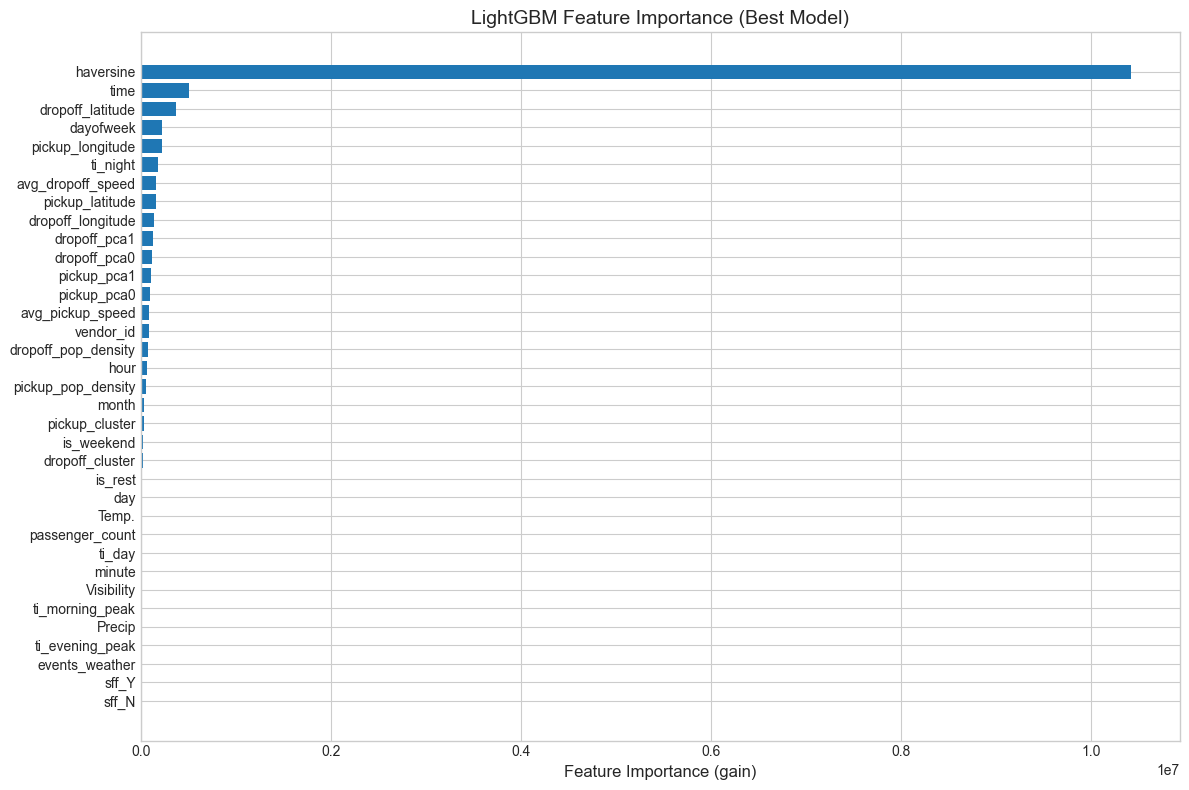

In [72]:
# 5.4.1 特征重要性可视化
# 获取特征名称（假设train_X是DataFrame，若为numpy数组可手动指定特征名）
feature_names = train_X.columns if hasattr(train_X, 'columns') else [f'feature_{i}' for i in range(train_X.shape[1])]

# 获取特征重要性（兼容sklearn接口的LightGBM）
importance_type = 'gain'  # 'split'表示分裂次数，'gain'表示总增益（更推荐）
# 关键修正：通过booster_获取底层模型，调用feature_importance方法
feature_importance = best_model.booster_.feature_importance(importance_type=importance_type)

# 排序特征重要性
sorted_idx = np.argsort(feature_importance)[::-1]  # 从高到低排序
sorted_importance = feature_importance[sorted_idx]
sorted_names = [feature_names[i] for i in sorted_idx]

# 绘制特征重要性条形图
plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_importance)), sorted_importance, align='center')
plt.yticks(range(len(sorted_importance)), sorted_names, fontsize=10)
plt.xlabel(f'Feature Importance ({importance_type})', fontsize=12)
plt.title('LightGBM Feature Importance (Best Model)', fontsize=14)
plt.gca().invert_yaxis()  # 让最重要的特征在顶部
plt.tight_layout()  # 调整布局避免文字截断
plt.show()

验证集预测结果（原始时间单位，前5行）：
   真实时间（秒）  预测时间（秒）  绝对误差（秒）  相对误差
0   558.00   490.86    67.14  0.12
1   436.00   533.33    97.33  0.22
2   302.00   327.70    25.70  0.09
3   563.00   476.59    86.41  0.15
4   190.00   281.81    91.81  0.48

【原始时间单位评估指标】（核心关注）
平均绝对时间差距：216.66 秒
均方根时间差距：377.02 秒
平均相对误差：34.47%
------------------------------------------------------------
【log尺度评估指标】（模型拟合参考）
log尺度RMSE：0.4025
log尺度R²：0.7301



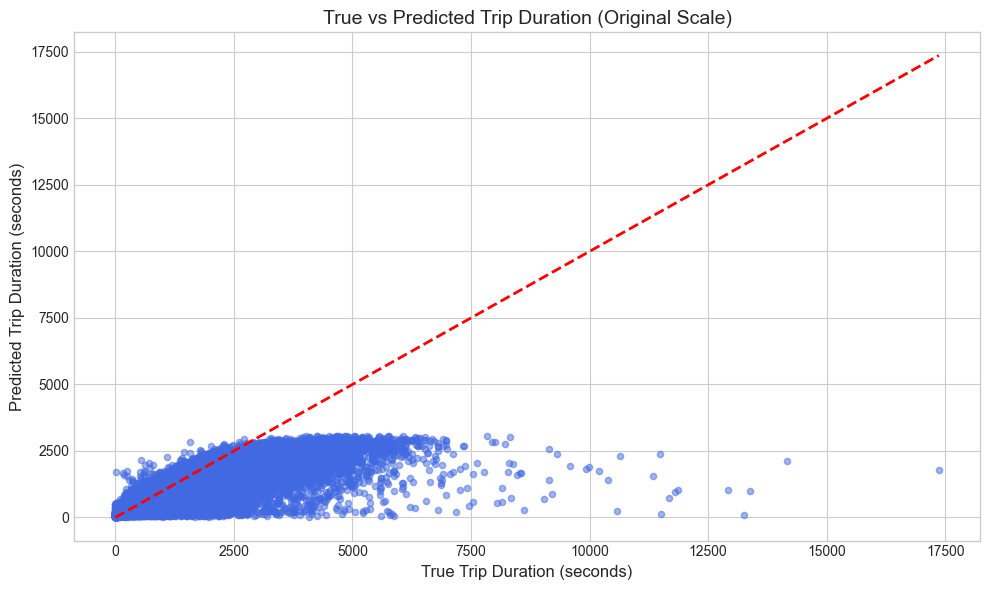

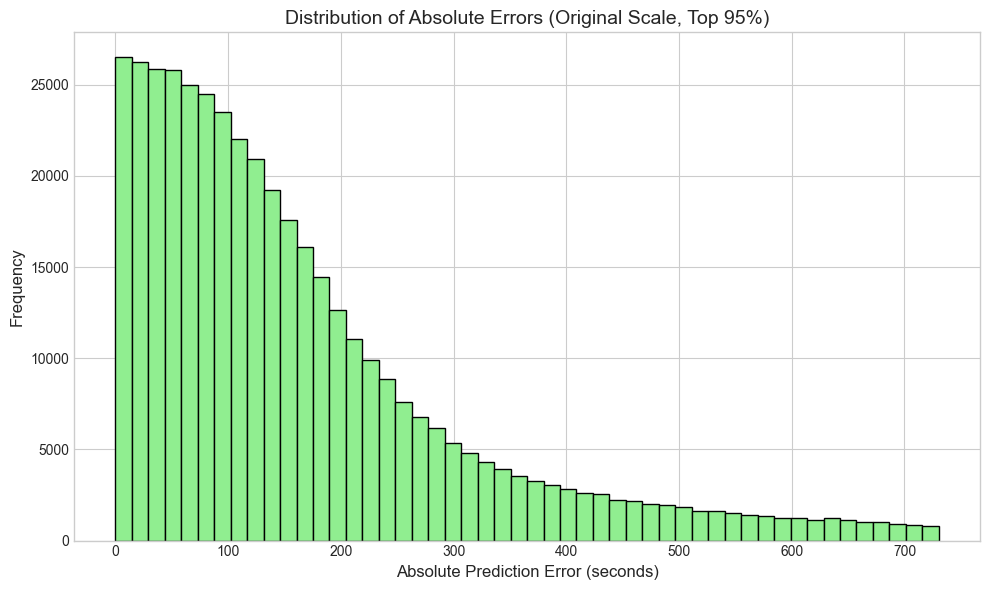

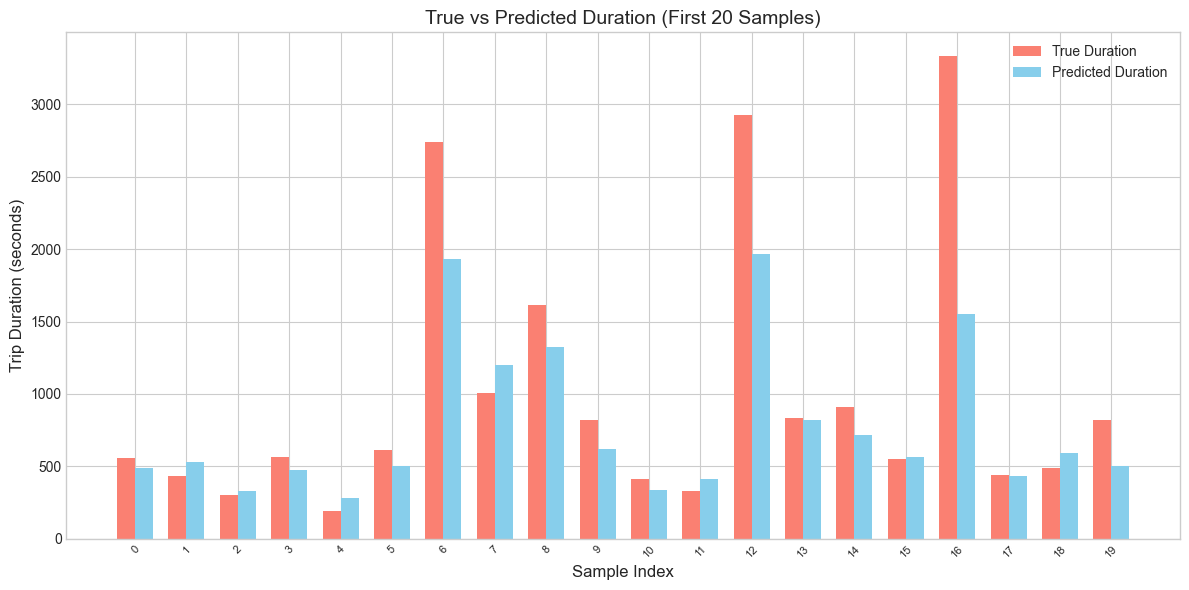

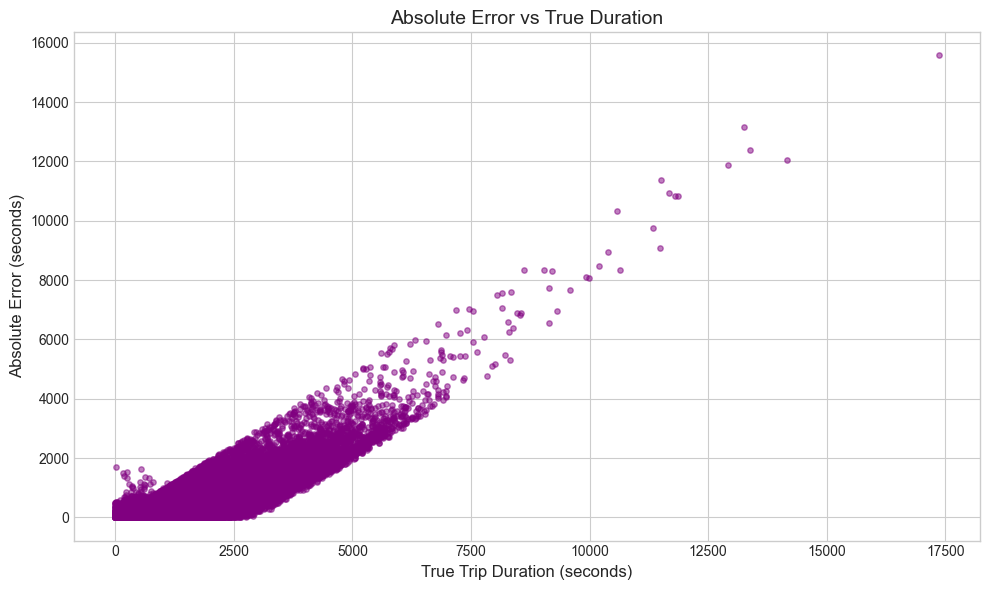


误差最大的10个样本（原始时间单位）：
        真实时间（秒）  预测时间（秒）  绝对误差（秒）  相对误差
394702 17363.00  1792.05 15570.95  0.90
19103  13260.00    85.15 13174.85  0.99
54527  13392.00   999.30 12392.70  0.93
38767  14171.00  2130.44 12040.56  0.85
81952  12926.00  1043.19 11882.81  0.92
433364 11513.00   143.06 11369.94  0.99
82676  11665.00   723.48 10941.52  0.94
164300 11804.00   955.37 10848.63  0.92
249084 11868.00  1045.39 10822.61  0.91
195811 10574.00   246.01 10327.99  0.98


In [74]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --------------------------
# 1. 生成验证集预测结果（含逆转换）
# --------------------------
# 1.1 用最佳模型预测验证集（log尺度）
val_pred_log = best_model.predict(val_X)  # 预测的是log_trip_duration
val_true_log = val_y.values              # 真实的log_trip_duration

# 1.2 逆转换：从log尺度还原为原始时间（trip_duration）
# 抵消之前的 log(x + 1) → 逆运算为 exp(log_x) - 1
val_pred = np.exp(val_pred_log) - 1  # 预测的原始时间（如秒）
val_true = np.exp(val_true_log) - 1  # 真实的原始时间（如秒）

# 1.3 整理结果（原始时间单位）
result_df = pd.DataFrame({
    '真实时间（秒）': val_true,
    '预测时间（秒）': val_pred,
    '绝对误差（秒）': np.abs(val_pred - val_true),  # 绝对差距
    '相对误差': np.abs(val_pred - val_true) / (val_true + 1e-6)  # 相对差距（加1e-6避免除0）
})
print("验证集预测结果（原始时间单位，前5行）：")
print(result_df.head())


# --------------------------
# 2. 计算量化评估指标（原始时间+log尺度）
# --------------------------
# 2.1 原始时间单位的指标（更关注这个，反映实际差距）
mae_time = mean_absolute_error(val_true, val_pred)  # 平均绝对时间差距（秒）
rmse_time = np.sqrt(mean_squared_error(val_true, val_pred))  # 均方根时间差距（秒）
mean_rel_error = result_df['相对误差'].mean() * 100  # 平均相对误差（百分比）

# 2.2 log尺度的指标（参考，用于对比模型拟合效果）
rmse_log = np.sqrt(mean_squared_error(val_true_log, val_pred_log))
r2_log = r2_score(val_true_log, val_pred_log)

print("\n" + "="*60)
print("【原始时间单位评估指标】（核心关注）")
print(f"平均绝对时间差距：{mae_time:.2f} 秒")  # 平均差多少秒
print(f"均方根时间差距：{rmse_time:.2f} 秒")    # 反映整体误差波动
print(f"平均相对误差：{mean_rel_error:.2f}%")  # 平均误差占真实时间的百分比
print("-"*60)
print("【log尺度评估指标】（模型拟合参考）")
print(f"log尺度RMSE：{rmse_log:.4f}")
print(f"log尺度R²：{r2_log:.4f}")
print("="*60 + "\n")


# --------------------------
# 3. 可视化预测结果（原始时间单位）
# --------------------------
plt.style.use('seaborn-v0_8-whitegrid')

# 3.1 真实时间vs预测时间散点图（判断整体趋势）
plt.figure(figsize=(10, 6))
plt.scatter(val_true, val_pred, alpha=0.5, s=20, color='royalblue')
# 添加参考线（y=x表示预测完全准确）
min_val = min(val_true.min(), val_pred.min())
max_val = max(val_true.max(), val_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
plt.xlabel('True Trip Duration (seconds)', fontsize=12)
plt.ylabel('Predicted Trip Duration (seconds)', fontsize=12)
plt.title('True vs Predicted Trip Duration (Original Scale)', fontsize=14)
plt.tight_layout()
plt.show()


# 3.2 绝对误差分布直方图（分析误差大小分布）
plt.figure(figsize=(10, 6))
# 可选：过滤极端大误差（让分布更清晰）
filtered_errors = result_df['绝对误差（秒）'][result_df['绝对误差（秒）'] < np.percentile(result_df['绝对误差（秒）'], 95)]
plt.hist(filtered_errors, bins=50, color='lightgreen', edgecolor='black')
plt.xlabel('Absolute Prediction Error (seconds)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Absolute Errors (Original Scale, Top 95%)', fontsize=14)
plt.tight_layout()
plt.show()


# 3.3 前20个样本的真实值vs预测值对比（个体差异）
plt.figure(figsize=(12, 6))
sample_df = result_df.head(20)  # 取前20个样本
x = np.arange(len(sample_df))
width = 0.35

plt.bar(x - width/2, sample_df['真实时间（秒）'], width, label='True Duration', color='salmon')
plt.bar(x + width/2, sample_df['预测时间（秒）'], width, label='Predicted Duration', color='skyblue')

plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Trip Duration (seconds)', fontsize=12)
plt.title('True vs Predicted Duration (First 20 Samples)', fontsize=14)
plt.xticks(x, sample_df.index, rotation=45, fontsize=8)
plt.legend()
plt.tight_layout()
plt.show()


# 3.4 误差随真实时间的变化（看是否某些区间误差更大）
plt.figure(figsize=(10, 6))
plt.scatter(val_true, result_df['绝对误差（秒）'], alpha=0.5, s=15, color='purple')
plt.xlabel('True Trip Duration (seconds)', fontsize=12)
plt.ylabel('Absolute Error (seconds)', fontsize=12)
plt.title('Absolute Error vs True Duration', fontsize=14)
plt.tight_layout()
plt.show()


# --------------------------
# 4. 误差较大样本分析（原始时间单位）
# --------------------------
# 按绝对误差排序，取误差最大的10个样本
top_error_samples = result_df.sort_values(by='绝对误差（秒）', ascending=False).head(10)
print("\n误差最大的10个样本（原始时间单位）：")
print(top_error_samples[['真实时间（秒）', '预测时间（秒）', '绝对误差（秒）', '相对误差']])

# （可选）查看这些样本的特征，分析误差原因
# print("\n误差最大样本的特征：")
# print(val_X.loc[top_error_samples.index])